In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors, rdmolfiles, rdMolAlign, rdmolops, rdchem, rdMolDescriptors, ChemicalFeatures, PeriodicTable, PropertyMol
from rdkit import DataStructs
from rdkit import RDLogger

from rdkit.Chem.Draw import IPythonConsole
from rdkit.Geometry import Point3D
from rdkit.Numerics.rdAlignment import GetAlignmentTransform
from rdkit.DataStructs import cDataStructs
from rdkit.Chem.Pharm2D.SigFactory import SigFactory
from rdkit.Chem.Pharm2D import Generate
from tqdm import tqdm, trange
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import scipy as sp
import shutil
import sklearn
import os
import random
import re
import subprocess
#import pmx
import gc
import time

import pmx
from pmx import ndx


try:
    import cPickle as pickle
except:
    import pickle
    
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Bohr2Ang=0.529177249
# RT=0.001985875*300 #kcal/mol

folder="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4"
pocket_fit_folder=f"{folder}/morphing_annealing_4d09/"

# Prep pickled ligands

In [3]:
#ligs
with open(folder+"/set_4_filtered_embedded_neutral_only.pickle", 'rb') as f:
    ligs = pickle.load(f)
    
# os.makedirs(pocket_fit_folder+"/morphes_sim_an_pickled_ligs", exist_ok=True)
# for i,lig in enumerate(tqdm(ligs)):
#     lig.SetProp('xray_name', '4d09')
#     fname = pocket_fit_folder+"/morphes_sim_an_pickled_ligs/{}.pickle".format(lig.GetProp('ID'))
#     if(not os.path.isfile(fname)):
#         pickle.dump( PropertyMol.PropertyMol(lig), open( fname, "wb" ) )

In [3]:
ids=[]
for i,lig in enumerate(tqdm(ligs)):
    ids.append( lig.GetProp('ID') )
del ligs

100%|██████████| 129223/129223 [00:00<00:00, 971659.74it/s]


In [4]:
import gc
gc.collect()

27

# Reload pickled ligands

In [5]:
#reload ligands from the pickle files
# def reload_ligs_from_pickles():
#     for i,lig in enumerate(tqdm(ligs)):
#         fname = pocket_fit_folder+"/morphes_sim_an_pickled_ligs/{}.pickle".format(lig.GetProp('ID'))
#         if(os.path.isfile(fname)):
#             ligs[i] = pickle.load( open( fname, "rb" ) )
#     print("Done reloading")
    
# reload_ligs_from_pickles()

# Prepare the environmental variables

In [6]:
variables = subprocess.Popen(
    ["bash", "-c", "trap 'env' exit; module load gmx/2021.1 > /dev/null 2>&1",
       "_"],
    shell=False, stdout=subprocess.PIPE).communicate()[0]

important_vars=["GROMACSDIR", "PATH", "GMXBIN", "LD_LIBRARY_PATH",
                "GMXLDLIB", "GMXMAN", "MANPATH", "GMXDATA"]

variables=variables.decode()
envs={}
for line in variables.splitlines():
    for var in important_vars:
        if line.startswith(var+"="):
            envs[var]=line.split('=')[1]
print(envs)
os.environ.update(envs)

{'LD_LIBRARY_PATH': '/usr/local/gromacs/2021/2021-impi2017-fftw337-gcc93-cuda11.1-fix3943//lib:/usr/local/intel/impi/3.2.1.009/lib64:/usr/local/cuda-11.1/lib64', 'GROMACSDIR': '/usr/local/gromacs/2021/2021-impi2017-fftw337-gcc93-cuda11.1-fix3943/', 'GMXBIN': '/usr/local/gromacs/2021/2021-impi2017-fftw337-gcc93-cuda11.1-fix3943//bin', 'GMXDATA': '/usr/local/gromacs/2021/2021-impi2017-fftw337-gcc93-cuda11.1-fix3943//share', 'GMXLDLIB': '/usr/local/gromacs/2021/2021-impi2017-fftw337-gcc93-cuda11.1-fix3943//lib', 'GMXMAN': '/usr/local/gromacs/2021/2021-impi2017-fftw337-gcc93-cuda11.1-fix3943//man', 'MANPATH': '/usr/local/gromacs/2021/2021-impi2017-fftw337-gcc93-cuda11.1-fix3943//man:/home/ykhalak/soft/env_modules/InstalledHere//share/man:/usr/local/man:/usr/share/man', 'PATH': '/home/ykhalak/soft/env_modules/InstalledHere//bin:/home/ykhalak/perl5/bin:/home/ykhalak/soft/Zotero_linux-x86_64:/home/ykhalak/soft/env_modules/InstalledHere/bin:/usr/local/gromacs/2021/2021-impi2017-fftw337-gcc93-c

In [7]:
! which gmx

/usr/local/gromacs/2021/2021-impi2017-fftw337-gcc93-cuda11.1-fix3943/bin/gmx


# Load the steps

In [8]:
os.chdir(pocket_fit_folder)

os.environ["TMPDIR"]=""

import sys
if 'morph_xray2lig_w_MDEnerg_in_TMPDIR' in sys.modules:
    import importlib
    importlib.reload(sys.modules['morph_xray2lig_w_MDEnerg_in_TMPDIR'])
else:
    import morph_xray2lig_w_MDEnerg_in_TMPDIR
from morph_xray2lig_w_MDEnerg_in_TMPDIR import *

# Run the protocol in the notebook

In [ ]:
import tempfile
import shutil

#os.environ["TMPDIR"] = tempfile.mkdtemp()
#os.environ["TMPDIR"]="/tmp/tmpet80lyf_"
#print(os.environ["TMPDIR"])

#create a temp setup folder
setup_folder_src=pocket_fit_folder+"/data/setup_morphes_sim_an"
setup_folder_dest=os.environ["TMPDIR"]+"/setup_morphes_sim_an"
os.system(f"cp -r {setup_folder_src} {setup_folder_dest}")

setup_folder_src=pocket_fit_folder+"/data/setup_energ"
setup_folder_dest=os.environ["TMPDIR"]+"/setup_energ"
os.system(f"cp -r {setup_folder_src} {setup_folder_dest}")

for i,lig_name in enumerate(tqdm(ids)):
    if(i!=2):
        continue;
    if(i>2):
        raise()
        
    lig_fn = pocket_fit_folder+"/morphes_sim_an_pickled_ligs/{}.pickle".format(lig_name)
    do_ligand(lig_fn, ncpus=8)
    
if(os.path.isdir(os.environ["TMPDIR"])):
    shutil.rmtree(os.environ["TMPDIR"], ignore_errors=True)
os.environ["TMPDIR"] = ""

os.chdir(pocket_fit_folder)
    
    #save progress ocassionally
#     if(i%20==0 and i>0):
#         pickle.dump( ligs, open( pocket_fit_folder+"/processed_ligs_w_morphing_sim_annealing.pickle", "wb" ) )
    
    #raise()

# Check completeness

In [9]:
# reload_ligs_from_pickles()
fnames_left=[]
ids_left=[]
processed=0
#for lig in ligs:
#     if(lig.HasProp('morphes done') and lig.GetProp('morphes done')=="yes"):
#         processed+=1
#     else:
#         fname = pocket_fit_folder+"/morphes_sim_an_pickled_ligs/{}.pickle".format(lig.GetProp('ID'))
#         fnames_left.append(fname)
#         ids_left.append(lig.GetProp('ID'))

for lig_name in tqdm(ids):
    fname = pocket_fit_folder+"/morphes_sim_an_pickled_ligs/{}.pickle".format(lig_name)
    if(os.path.isfile(fname)):
        lig = pickle.load( open( fname, "rb" ) )
    if(lig.HasProp('morphes done') and lig.GetProp('morphes done')=="yes"):
        processed+=1
    else:
#         fname = pocket_fit_folder+"/morphes_sim_an_pickled_ligs/{}.pickle".format(lig_name)
        fnames_left.append(fname)
        ids_left.append(lig.GetProp('ID'))

print("morphes done:", processed,"/",len(ids), "\t", 100*processed/len(ids), "%", "\tleft:", len(ids)-processed)

  9%|▉         | 12096/129223 [01:17<12:31, 155.89it/s]


KeyboardInterrupt: 

In [ ]:
print("morphes done:", processed,"/",len(ids), "\t", 100*processed/len(ids), "%", "\tleft:", len(ids)-processed)

In [10]:
ids_left2=[]
processed=0

for lig_name in tqdm(ids_left):
    fname = pocket_fit_folder+"/morphes_sim_an_pickled_ligs/{}.pickle".format(lig_name)
    if(os.path.isfile(fname)):
        lig = pickle.load( open( fname, "rb" ) )
    if(lig.HasProp('morphes done') and lig.GetProp('morphes done')=="yes"):
        processed+=1
    else:
        ids_left2.append(lig.GetProp('ID'))

print("morphes done:", processed,"/",len(ids_left), "\t", 100*processed/len(ids_left), "%", "\tleft:", len(ids_left)-processed)

100%|██████████| 1624/1624 [00:28<00:00, 57.29it/s] 

morphes done: 158 / 1624 	 9.729064039408867 % 	left: 1466


In [11]:
ids_left=ids_left2

# Run protocol on owl

In [12]:
import queue
import threading

previously_done=0
#max_debug_evals=3
max_debug_evals=200000

#reload_ligs_from_pickles()

q = queue.Queue()
#for i,lig in enumerate(tqdm(ligs)):
#     if(lig.HasProp('morphes done') and lig.GetProp('morphes done')=="yes"):
#         previously_done+=1
#         continue; #already handled

ids_to_use=ids_left
    
for lig_id in tqdm(ids_to_use):
    #lig_fn = pocket_fit_folder+"/morphes_sim_an_pickled_ligs/{}.pickle".format(lig.GetProp('ID'))
    lig_fn = pocket_fit_folder+"/morphes_sim_an_pickled_ligs/{}.pickle".format(lig_id)
    q.put(lig_fn)

    if(q.qsize()>=max_debug_evals):
        break;
        
print("previously_done:", previously_done, "\t out of:", len(ids_to_use), flush=True)
#nligs_left=len(ligs)-previously_done
nligs_left=len(ids_to_use)-previously_done
nligs_left=min(nligs_left, max_debug_evals)
nworkers=200
nligs_per_worker=int(np.ceil(float(nligs_left)/nworkers))
print("ligands left:", nligs_left, "\t # workers:", nworkers, "\t # ligands/worker:", nligs_per_worker)
print("estimated time:", 170 * nligs_per_worker, "s or", 170 * nligs_per_worker / 3600, "h")

cwd=pocket_fit_folder+"/morphes_sim_an_owl_jobscripts/"
os.makedirs(cwd, exist_ok=True)
cmd_str="source /etc/profile; module load sge; cd {};".format(cwd)

def worker(job_id):
#     print("worker", job_id)
    ligands_str=""
    for l in range(nligs_per_worker):
        fname = q.get()
        if fname is None:  # EOF?
            break
        ligands_str+=" "+fname
    if not ligands_str: # skip empty jobs
        return;
    cwd=pocket_fit_folder+"/morphes_sim_an_owl_jobscripts/"
    if(not os.path.isdir(cwd)):
        os.makedirs(cwd)
#     cwd=pocket_fit_folder
    jobscript_str="""
#!/bin/bash
#$ -S /bin/bash
#$ -pe openmp_* 4
#$ -q *
#$ -N pde2_lig_struct_from_morphing_{}
#$ -M ykhalak@gwdg.de
#$ -m n
#$ -l h_rt=24:00:00
#$ -l gm='!rtx2080'
#$ -wd {}

source ~/.ML_profile
source /usr/local/gromacs/GMXRC2021

python {}/morph_xray2lig_w_MDEnerg_in_TMPDIR.py -n 4 -f {}
""".format(job_id, cwd, pocket_fit_folder, ligands_str)
    jobscript_fn=cwd+"/jobscript_{}".format(job_id)
    with open(jobscript_fn,"w") as f:
        f.write(jobscript_str)

    global cmd_str
    cmd_str+=" qsub {};".format(jobscript_fn)
#     ssh_cmd_arr=["ssh", "owl", "source /etc/profile; module load sge; cd {}; qsub {};".format(cwd, jobscript_fn)]
#     process = subprocess.Popen(ssh_cmd_arr, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#     process.wait()


for job_id in range(nworkers):
    q.put(None)
    worker(job_id)
    
    
#print(cmd_str)
#raise()
    
print("Submitting.")
ssh_cmd_arr=["ssh", "owl", cmd_str]
process = subprocess.Popen(ssh_cmd_arr, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
process.wait()
print("Done.")

100%|██████████| 1466/1466 [00:00<00:00, 240443.03it/s]

previously_done: 0 	 out of: 1466


ligands left: 1466 	 # workers: 200 	 # ligands/worker: 8
estimated time: 1360 s or 0.37777777777777777 h
Submitting.
Done.


In [ ]:
# print(cmd_str.replace('; ', '\n'), file=open(cwd+"/submit.sh", "w"))

# remove folders for all the failures

In [ ]:
import shutil
for id_name in ids_left2:
    if os.path.exists(pocket_fit_folder+"/data/ligand/{}".format(id_name)):
        shutil.rmtree(pocket_fit_folder+"/data/ligand/{}".format(id_name))
    if os.path.exists(pocket_fit_folder+"/morphes_sim_an/{}".format(id_name)):
        shutil.rmtree(pocket_fit_folder+"/morphes_sim_an/{}".format(id_name))

# debug failures

In [ ]:
print(ids_left[:10], "...")

In [ ]:
import sys
if 'morph_xray2lig' in sys.modules:
    import importlib
    def reload( module ):
        import os
        import os.path
        import importlib

        cwd = os.getcwd()
        os.chdir( os.path.dirname(os.path.abspath(module.__file__)) )
        importlib.reload( module )
        os.chdir( cwd )
    reload(sys.modules['morph_xray2lig'])
else:
    import morph_xray2lig
from morph_xray2lig import *

do_ligand("/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing//morphes_sim_an_pickled_ligs/set4_230.pickle")

In [ ]:
target="set4_230"
# for i in range(len(ligs)):
#     if target == ligs[i].GetProp('ID'):
#         print(i, ligs[i].GetProp('ID'))
#         break;
lig_fn = pocket_fit_folder+"/morphes_sim_an_pickled_ligs/{}.pickle".format(target)
with open(lig_fn, 'rb') as f:
    lig = pickle.load(f)

noH=rdmolops.RemoveHs(lig)
reH=rdmolops.AddHs(noH, addCoords=True)
Draw.MolsToGridImage([lig, noH, reH ],subImgSize = (400,400), molsPerRow=3)

# Save result

In [10]:
# reload_ligs_from_pickles()
#pickle.dump( ligs, open( pocket_fit_folder+"/processed_ligs_w_morphing_sim_annealing.pickle", "wb" ) )

# reload_ligs_from_pickles()
fnames_left=[]
ids_left=[]
processed=0
ligs_complete=[]
for lig_name in tqdm(ids):
    fname = pocket_fit_folder+"/morphes_sim_an_pickled_ligs/{}.pickle".format(lig_name)
    if(os.path.isfile(fname)):
        lig = pickle.load( open( fname, "rb" ) )
    if(lig.HasProp('morphes done') and lig.GetProp('morphes done')=="yes"):
        processed+=1
        ligs_complete.append(lig)
    else:
#         fname = pocket_fit_folder+"/morphes_sim_an_pickled_ligs/{}.pickle".format(lig_name)
        fnames_left.append(fname)
        ids_left.append(lig.GetProp('ID'))

print("morphes done:", processed,"/",len(ids), "\t", 100*processed/len(ids), "%", "\tleft:", len(ids)-processed)
pickle.dump( ligs_complete, open( pocket_fit_folder+"/processed_ligs_w_morphing_sim_annealing_only_sucessfull_4d09.pickle", "wb" ) )


100%|██████████| 129223/129223 [12:50<00:00, 167.66it/s] 


morphes done: 128846 / 129223 	 99.70825627016862 % 	left: 377


# remove ligands with strange chemistry

In [12]:
ligs_to_save=[]
ligs_weird=[]

weird = [Chem.MolFromSmarts('[N;!R]~N'), Chem.MolFromSmarts('O~O')]
# print(m.GetSubstructMatches(substructure))

for lig in tqdm(ligs_complete):
    matches=[len(lig.GetSubstructMatches(w))>0 for w in weird]
    if(any(matches)):
        ligs_weird.append(lig)
    else:
        ligs_to_save.append(lig)
pickle.dump( ligs_to_save, open( pocket_fit_folder+"/sucessfull_4d09_without_weird_chemistry.pickle", "wb" ) )

100%|██████████| 128846/128846 [00:00<00:00, 131654.91it/s]


5319


/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/rdkit/Chem/Draw/IPythonConsole.py:192: UserWarning: Truncating the list of molecules to be displayed to 100. Change the maxMols value to display more.
  % (maxMols))


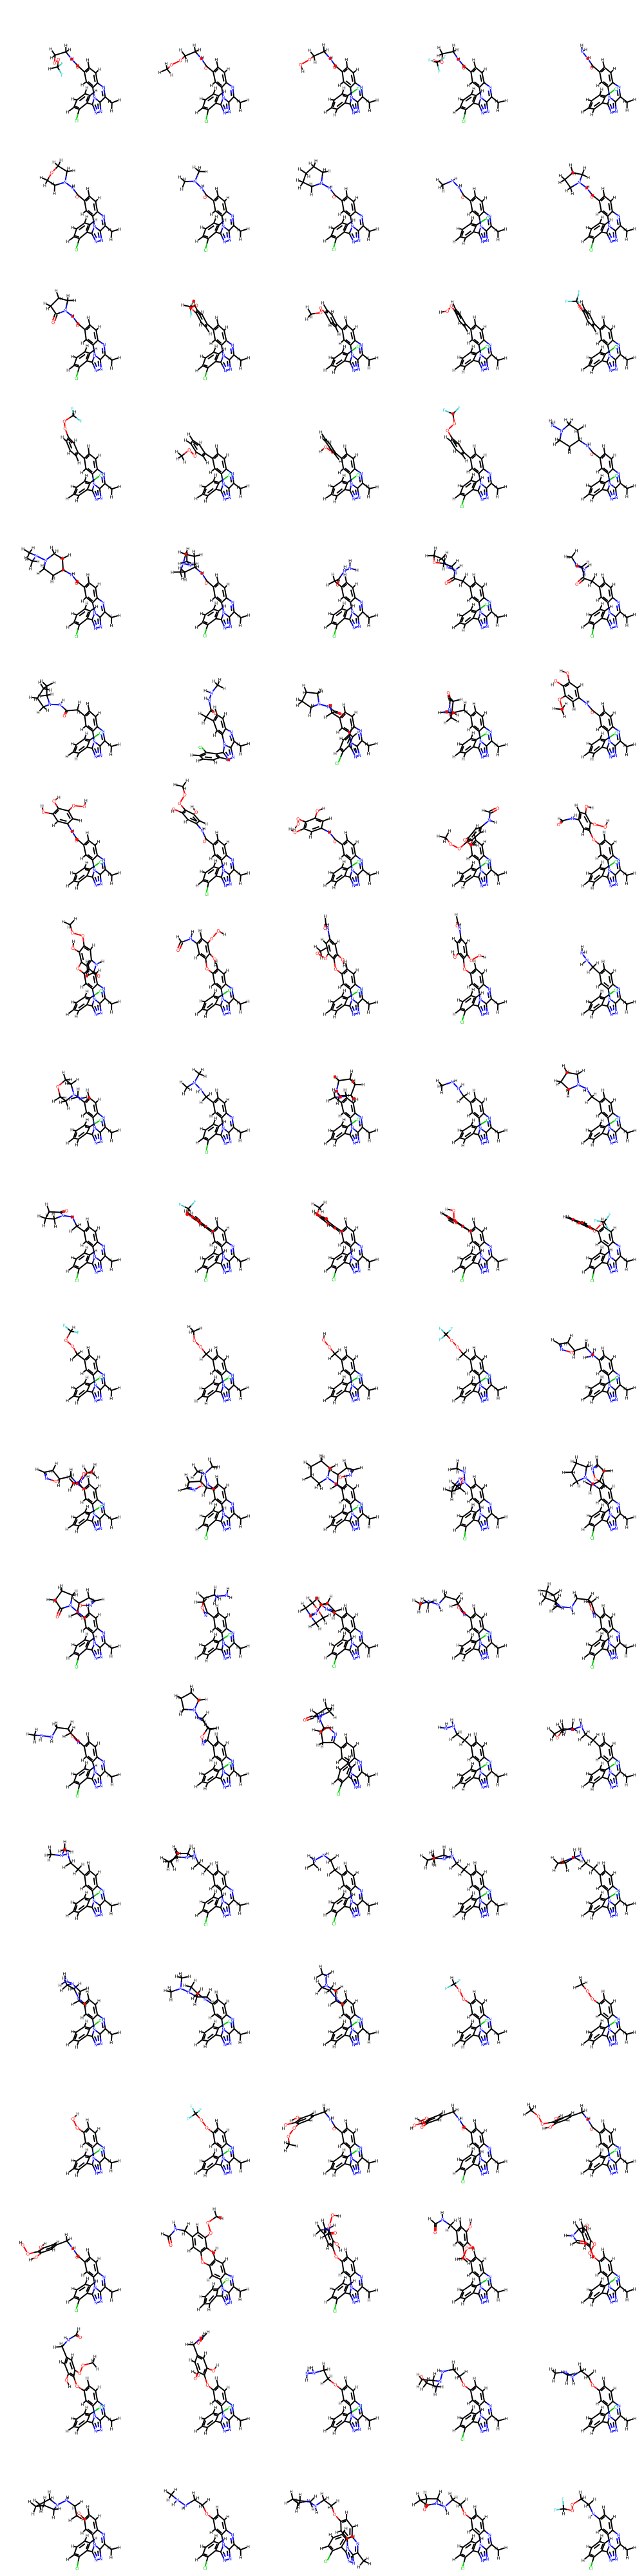

In [14]:
print(len(ligs_weird))
Draw.MolsToGridImage(ligs_weird, subImgSize = (200,200), molsPerRow=5, maxMols=100)

# remove validation ligands

In [ ]:
training_databse_fn="/home/ykhalak/Projects/ML_dG/pde2_dG//aligned_w_pmx_library_new_structures_similar2xrays.pickle"
with open(training_databse_fn, 'rb') as f:
    training_ligs = pickle.load(f)
training_ligs=[l for l in training_ligs if not("<" in l.GetProp("[Q] hPDE2_pIC50") or ">" in l.GetProp("[Q] hPDE2_pIC50"))]

from rdkit.Chem import rdRGroupDecomposition as rdRGD
with suppress_stdout_stderr():
    res,unmatched = rdRGD.RGroupDecompose([core], training_ligs, asSmiles=True)# print(unmatched)
matched_training_ligs=[ligs[i] for i in range(len(ligs)) if not i in unmatched]

#filter out H's as R-groups
validation_ligs=[]
for i,l in enumerate(tqdm(res)):
    new_l={}
    for rg in l:
        if rg=='Core':
            continue;
        if l[rg][:3]!='[H]':
            new_l[rg]=l[rg]
    if(len(new_l)==1):
        validation_ligs.append(matched_training_ligs[i])
print(len(validation_ligs))

del training_ligs, training_databse_fn, matched_training_ligs, res, unmatched
gc.collect()

validation_smiles=[Chem.MolToSmiles(rdmolops.RemoveHs(lig)) for lig in validation_ligs]

In [10]:
with open(pocket_fit_folder+"/sucessfull_4d09_without_weird_chemistry.pickle", 'rb') as f:
    ligs = pickle.load(f)

ligs_to_save=[]
for lig in tqdm(ligs):
    if(Chem.MolToSmiles(rdmolops.RemoveHs(lig)) not in validation_smiles):
        ligs_to_save.append(lig)
print(len(ligs_to_save))
pickle.dump( ligs_to_save, open( pocket_fit_folder+"/sucessfull_4d09_without_weird_chemistry_and_validation_ligs.pickle", "wb" ) )

del ligs
gc.collect()

100%|██████████| 123527/123527 [00:36<00:00, 3359.59it/s]


123515


0

# Compute MDEnerg representation
### 1. Find residues in contact with the ligands
- Specifically residues within 1.5 nm of the crystal structure. This should be enough for the various R-groups to flail around a bit in the solvent.

In [ ]:
import MDAnalysis as md
import nglview as nv

from MDAnalysis.analysis import align, distances
from MDAnalysis.analysis.rms import rmsd

In [ ]:
os.chdir(pocket_fit_folder)

In [ ]:
#load the protein
u_prot = md.Universe(pocket_fit_folder+"/data/setup/prot.pdb")
protein = u_prot.select_atoms('protein')

u_xray = md.Universe(pocket_fit_folder+"data/xrays/4d09/MOL.pdb")
xray = u_xray.select_atoms('all')

# w = nv.show_mdanalysis(protein)
# w.add_trajectory(lig)
# #w = nv.show_mdanalysis(lig)
# w

In [ ]:
#find all residues that can be in conctact with xtal ligands
xray_pos=xray.positions

# residue pos
dist_mat=distances.distance_array(protein.positions, xray_pos)
dist_mask=dist_mat<=15
dist_mask=np.any(dist_mask, axis=1)
#print(dist_mask.shape)
close_atoms_idxs=np.where(dist_mask)[0]
close_atoms=protein[close_atoms_idxs]
close_residues=close_atoms.residues
print(close_residues)
print(len(close_residues))
print(len(protein.residues))

close_atoms=close_residues.atoms
print(close_atoms_idxs.shape)

In [ ]:
setup_energ_folder=pocket_fit_folder+"/data/setup_energ/"

with open(setup_energ_folder+f"close_prot_residues.ndx", 'w') as f:
    for i in range(len(close_residues.resids)):
        rid=close_residues.resids[i]
        aids=close_residues[i].atoms.ids
        print(f"[ r_{rid} ]", file=f)
        for j in range(len(aids)):
            print(f"{aids[j]:6d} ", end='', file=f)
            if(j%10==9 and j<len(aids)-1):
                print('', file=f)
        print("\n", file=f)

In [ ]:
eblocks=[]
block=[]
block.append("Ion")
for i in range(len(close_residues.resids)):
    rid=close_residues.resids[i]
    print(f"r_{rid} ", end='')
    block.append(f"r_{rid}")
    if(i%61==60):
        print("\n\n", end='')
        eblocks.append(block)
        block=[]
eblocks.append(block)
del block

print()

In [ ]:
#write input files for gmx energy

etypes=["Coul-SR", "LJ-SR"]

eblocks_keys=[]
for i,block in enumerate(eblocks):
    with open(setup_energ_folder+f"g_energy_block_{i+1}_input.txt", 'w') as f:
        for r in block:
            pair=f"ligand-{r}"
            for t in range(len(etypes)):
                print(f"{etypes[t]}:{pair}", file=f)
#         break;

# Compute electrostatic potentials for the sucessfully morphed ligands

In [ ]:
Bohr2Ang=0.529177249
def write_gaussian_inp(mol, fn, ncpu=8):
    with open(fn,"w") as f:
        f.write("%chk=check.chk\n") #checkpoint file
        


        #f.write("%CPU=0-7\n") #parallelize across 8 threads (pinned to cores?)
        f.write("%NProcShared={}\n".format(ncpu)) #parallelize across 8 threads (no pinning to cores)
        #f.write("#P Becke3LYP/6-31G(d) scf=tight formcheck NoSymmetry\n\n") #pseudopot, wavefuncs, convergence level, checkpoint file "Test.FChk"
        f.write("#HF/CEP-31G SCF=tight Test iop(6/33=2) iop(6/42=6) formcheck NoSymmetry\n\n") #Hartree-Fock/basis, convergence level, .. , checkpoint file "Test.FChk", no symetry
        f.write("ESP generation\n\n") #title
        f.write("{} 1\n".format(rdmolops.GetFormalCharge(mol))) #charge, multiplicity (singlet state)
        
        atoms = mol.GetAtoms()
        coords = mol.GetConformer().GetPositions()
        for i in range(len(mol.GetAtoms())):
            a=atoms[i]
            x,y,z=coords[i]
            f.write("{}, 0, {}, {}, {}\n".format(a.GetSymbol(), x,y,z)) #atoms
        f.write("\n\n") #EOF

def run_gaussian(inp_fn, cwd="/home/ykhalak/Projects/ML_dG/pde2_dG/how_do_ligs_fit_in_pocket/ESP_from_morphes_sim_an/gaussian_temp",
                 local=True, lig="?", ncpu=8):
    if local:
        my_env = os.environ.copy()
        my_env["GAUSS_EXEDIR"] = "/usr/local/gaussian/g09"
        g_exe="/usr/local/gaussian/g09/g09"
        inp_file = open(inp_fn,'r')
        out_file = open(cwd+"/scf.log", 'w')
        process = subprocess.Popen(g_exe, stdin=inp_file, stdout=out_file , env=my_env, cwd=cwd)
        process.wait()
        inp_file.close()
        out_file.close()
    
    else: #run on owl
        jobscript_str="""
#!/bin/bash
#$ -S /bin/bash
#$ -pe openmp_* {}
#$ -q *
#$ -N gaussian_SCF_pde2_lig_{}
#$ -M ykhalak@gwdg.de
#$ -m n
#$ -l h_rt=2:00:00
#$ -wd {}

export GAUSS_EXEDIR="/usr/local/gaussian/g09"
/usr/local/gaussian/g09/g09 < {} 2>&1 > scf.log
""".format(ncpu, lig, cwd, inp_fn)
        with open(cwd+"/jobscript","w") as f:
            f.write(jobscript_str)
        ssh_cmd_arr=["ssh", "owl", "source /etc/profile; module load sge; cd {}; qsub jobscript;".format(cwd)]
        process = subprocess.Popen(ssh_cmd_arr)
        process.wait()

        
#find out coordinates assigned by Gaussian
def read_gaussian_transform_matrix_from_fchk(mol, fn):
    conf=mol.GetConformers()[0]
    coords=[]
    N=-1
    with open(fn,"r") as f:
        bcoords=False
        for line in f:
            if "Current cartesian coordinates" in line: #start of coords block
                bcoords=True
                N=int(int(line.split()[-1])/3)
            elif "Number of symbols in" in line: #end of coords block
                bcoords=False
                break;  
            elif bcoords: #read coords
                s=line.split()
                for n in s:
                    coords.append(float(n))
                    
    coords=np.array(coords).reshape((-1,3))
    coords*=Bohr2Ang #convert to Angstoms
    
    return(GetAlignmentTransform(coords, conf.GetPositions())[1]) #original into Gaussian coords


def make_cube(cubefn, M, ncpu=8, N=32, spacing=0.6,
              fchk="Test.FChk", cwd="/home/ykhalak/Projects/ML_dG/pde2_dG/how_do_ligs_fit_in_pocket/ESP_from_morphes_sim_an/gaussian_temp",
              local=True, lig="?"):
    M_rot = np.zeros((4,4))
    M_rot[:,:3]=M[:,:3] #rotation and shear matrix. No translation. Shear should be 0.

    def transform_vec(vec, M):
        v=np.append(vec, 1.0)
        return(np.matmul(M, v)[:-1])

    #grid specification
    #center=np.array([0.0,0.0,0.0]) #A;     
    center=grid_center
    offset=(N-1)*spacing/2
    corner=center-offset #corner in scaffold coord space
    corner=transform_vec(corner, M) #corner in gaussian coord space (in A)
    inp="-1,{:f},{:f},{:f}\n".format(corner[0], corner[1], corner[2])
    for k in range(3):
        uvec=np.zeros(3)
        uvec[k]=spacing
        uvec=transform_vec(uvec, M_rot) #rotate (and shear) only, do not translate
        inp+="{},{:f},{:f},{:f}\n".format(int(N[k]), uvec[0], uvec[1], uvec[2])

    cube_exe="/usr/local/gaussian/g09/cubegen"
    cmd="{} {} Potential=SCF {} {} -1 h".format(
        cube_exe, ncpu, fchk, cubefn)
    
#     print(inp)
        
    if local:
        my_env = os.environ.copy()
        my_env["GAUSS_EXEDIR"] = "/usr/local/gaussian/g09"
        cmd=cmd.split()
        out_file = open(cwd+"/cubegen.log", 'w')
        process = subprocess.Popen(cmd, stdin=subprocess.PIPE, stdout=out_file, stderr=out_file, env=my_env, cwd=cwd)
        process.communicate(bytes(inp, 'utf-8'))
        process.wait()
        out_file.close()
    else: #run on owl
        inp_fn=cwd+"/cubegen.inp"
        with open(inp_fn,"w") as f:
            f.write(inp)
        jobscript_str="""
#!/bin/bash
#$ -S /bin/bash
#$ -pe openmp_* {}
#$ -q *
#$ -N gaussian_cubegen_pde2_lig_{}
#$ -M ykhalak@gwdg.de
#$ -m n
#$ -l h_rt=1:00:00
#$ -wd {}

export GAUSS_EXEDIR="/usr/local/gaussian/g09"
{} < {} 2>&1 > cubegen.log
""".format(ncpu, lig, cwd, cmd, inp_fn)
        with open(cwd+"/jobscript_cube","w") as f:
            f.write(jobscript_str)
            
        ssh_cmd_arr=["ssh", "owl", "source /etc/profile; module load sge; cd {}; qsub jobscript_cube;".format(cwd)]
        process = subprocess.Popen(ssh_cmd_arr)
#         process.wait()


In [ ]:
ligs_finished = pickle.load( open( pocket_fit_folder+"/processed_ligs_w_morphing_sim_annealing_only_sucessfull.pickle", "rb" ) )

In [ ]:
# #for each ligand find max/min coordinates of atoms
# grid_min=np.array([9999,9999,9999])
# grid_max=-grid_min
# for lig in tqdm(ligs):
#     v=lig.GetConformer().GetPositions()
#     v_min=np.min(v, axis=0)
#     v_max=np.max(v, axis=0)
    
#     grid_min=np.min([v_min,grid_min], axis=0)
#     grid_max=np.max([v_max,grid_max], axis=0)


# print("grid limit from atoms are:", grid_min, grid_max)
# grid_center=(grid_max+grid_min)/2

# grid_spacing=2 # A
# padding=4      # A
# grid_min-=padding
# grid_max+=padding
# grid_size=np.ceil((grid_max-grid_min)/grid_spacing)
# print("grid size is:", grid_size)
# v=np.max(grid_size)
# grid_size=np.array([v,v,v])
# print("grid size after ensuring cubic grid is:", grid_size)

# #new grid limits with padding and centered on the same spot
# grid_min=grid_center-grid_size*grid_spacing/2
# grid_max=grid_center+grid_size*grid_spacing/2
# print("final grid limit are:", grid_min, grid_max)

In [ ]:
# grid params from training set
grid_spacing=2 # A
padding=4      # A
grid_size=np.array([16,16,16])
grid_min = np.array([2.00700021, -7.59749997, -24.80950016])
grid_max = np.array([34.00700021, 24.40250003, 7.19049984])
grid_center=(grid_max+grid_min)/2

In [ ]:
import shutil

ESP_folder=pocket_fit_folder+"/ESP_from_morphes_sim_an/"

gaussian_to_run=[]
cubegen_to_run=[]

#repeat the above for library
for lig in tqdm(ligs_finished):
    key=lig.GetProp('ID')
    directory = ESP_folder+"/lig_{}/".format(key)
    
    lM=None
    os.makedirs(directory, exist_ok=True)
    
    #save a pdb of the ligand
    with open(directory+"/input.pdb","w") as f:
        f.write(rdmolfiles.MolToPDBBlock(lig, flavor=0))
    
    #write gaussian input file
    inp_fn=directory+"/lig_{}.inp".format(key)
    fchk=directory+"/Test.FChk"
    cub_fn=directory+"/lig_{}_pad_{}_a_{}.cub".format(key, padding, grid_spacing)
    
#     if not os.path.isfile(fchk):
#         print("SCF not done:", key)

#     if not os.path.isfile(cub_fn):
#         print("Gencube not done:", cub_fn, "\n")
    
    if not os.path.isfile(inp_fn) or not os.path.isfile(fchk):
        write_gaussian_inp(lig, inp_fn, ncpu=4)
    
    #run gaussian
    if not os.path.isfile(fchk):
        #run_gaussian(inp_fn, cwd=directory, lig=key, local=False, ncpu=4)
        gaussian_to_run.append({"inp_fn": inp_fn, "cwd": directory, "lig": key, "local": False, "ncpu":4})

    
    #find transform matrix
    if not os.path.isfile(cub_fn) and os.path.isfile(fchk):
        lM = read_gaussian_transform_matrix_from_fchk(lig, fchk)
    
    #make cubefile
    if not os.path.isfile(cub_fn) and os.path.isfile(fchk):
        #make_cube(cub_fn, lM, cwd=directory, fchk=fchk, local=True, lig=key, ncpu=4, N=grid_size, spacing=grid_spacing)
        cubegen_to_run.append({"cubefn": cub_fn, "M": lM, "cwd": directory, "fchk": fchk, "lig": key, "local": False, "ncpu":4,
                               "N": grid_size, "spacing":grid_spacing})
    #break;

In [ ]:
print("Need to run Gaussian on", len(gaussian_to_run), "ligands")
print("Need to run Cubegen on", len(cubegen_to_run), "ligands")

In [ ]:
print("Need to run Gaussian on", len(gaussian_to_run), "ligands")

import queue
import threading

previously_done=0
max_debug_evals=35000

q = queue.Queue()
for i,d in enumerate(tqdm(gaussian_to_run)):
    q.put(d)
    if(q.qsize()>=max_debug_evals):
        break;
        
nworkers=10
nligs_per_worker=int(np.ceil(float(q.qsize())/nworkers))
        
print("Will run Gaussian on", q.qsize(), "ligands")
print(f"Will use {nligs_per_worker} ligands per jobs and {nworkers} jobs")

cwd=pocket_fit_folder+"/ESP_from_morphes_sim_an_gaussian_jobscripts/"
os.makedirs(cwd, exist_ok=True)
cmd_str="source /etc/profile; module load sge; cd {};".format(cwd)

def worker(job_id):
    if(not os.path.isdir(cwd)):
        os.makedirs(cwd)

    jobscript_str=f"""
#!/bin/bash
#$ -S /bin/bash
#$ -pe openmp_* {4}
#$ -q *
#$ -N gaussian_SCF_pde2_worker_{job_id}
#$ -M ykhalak@gwdg.de
#$ -m n
#$ -l h_rt=23:00:00
#$ -wd {cwd}

export GAUSS_EXEDIR="/usr/local/gaussian/g09"

"""
    nligs_here=0
    for l in range(nligs_per_worker):
        d = q.get()
        if d is None:  # EOF?
            break
        jobscript_str+=f"\ncd {d['cwd']}\n"
        jobscript_str+=f"/usr/local/gaussian/g09/g09 < {d['inp_fn']} 2>&1 > scf.log\n"
        nligs_here+=1
    if nligs_here<=0: # skip empty jobs
        return;
    
    jobscript_fn=cwd+"/jobscript_{}".format(job_id)
    with open(jobscript_fn,"w") as f:
        f.write(jobscript_str)

    global cmd_str
    cmd_str+=" qsub {};".format(jobscript_fn)


for job_id in range(nworkers):
    q.put(None)
    worker(job_id)
    
    
#print(cmd_str)
#raise()
    
print("Submitting.")
ssh_cmd_arr=["ssh", "owl", cmd_str]
process = subprocess.Popen(ssh_cmd_arr, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
process.wait()
print("Done.")

# Cubegen

In [ ]:
print("Need to run Cubegen on", len(cubegen_to_run), "ligands")

import queue
import threading

previously_done=0
max_debug_evals=32000

q = queue.Queue()
for i,d in enumerate(tqdm(cubegen_to_run)):
    if(os.path.isfile(d['cubefn'])):
        continue
    q.put(d)
    if(q.qsize()>=max_debug_evals):
        break;
        
nworkers=20
nligs_per_worker=int(np.ceil(float(q.qsize())/nworkers))
        
print("Will run Cubegen on", q.qsize(), "ligands")
print(f"Will use {nligs_per_worker} ligands per jobs and {nworkers} jobs")

cwd=pocket_fit_folder+"/ESP_from_morphes_sim_an_cubegen_jobscripts/"
cube_exe="/usr/local/gaussian/g09/cubegen"
os.makedirs(cwd, exist_ok=True)
cmd_str="source /etc/profile; module load sge; cd {};".format(cwd)

def get_cubegen_input(M, N, spacing):
    M_rot = np.zeros((4,4))
    M_rot[:,:3]=M[:,:3] #rotation and shear matrix. No translation. Shear should be 0.

    def transform_vec(vec, M):
        v=np.append(vec, 1.0)
        return(np.matmul(M, v)[:-1])

    #grid specification
    #center=np.array([0.0,0.0,0.0]) #A;     
    center=grid_center
    offset=(N-1)*spacing/2
    corner=center-offset #corner in scaffold coord space
    corner=transform_vec(corner, M) #corner in gaussian coord space (in A)
    inp="-1,{:f},{:f},{:f}\n".format(corner[0], corner[1], corner[2])
    for k in range(3):
        uvec=np.zeros(3)
        uvec[k]=spacing
        uvec=transform_vec(uvec, M_rot) #rotate (and shear) only, do not translate
        inp+="{},{:f},{:f},{:f}\n".format(int(N[k]), uvec[0], uvec[1], uvec[2])
    return(inp)

def worker(job_id):
    if(not os.path.isdir(cwd)):
        os.makedirs(cwd)

    jobscript_str=f"""
#!/bin/bash
#$ -S /bin/bash
#$ -pe openmp_* {4}
#$ -q *
#$ -N cubegen_pde2_worker_{job_id}
#$ -M ykhalak@gwdg.de
#$ -m n
#$ -l h_rt=12:00:00
#$ -wd {cwd}

export GAUSS_EXEDIR="/usr/local/gaussian/g09"

"""
    nligs_here=0
    for l in range(nligs_per_worker):
        d = q.get()
        if d is None:  # EOF?
            break
            
        inp_fn=d['cwd']+"/cubegen.inp"
        with open(inp_fn,"w") as f:
            f.write(get_cubegen_input(d['M'], d['N'], d['spacing']))
            
        jobscript_str+=f"\ncd {d['cwd']}\n"
        jobscript_str+=f"{cube_exe} {4} Potential=SCF {d['fchk']} {d['cubefn']} -1 h < {inp_fn} 2>&1 > cubegen.log\n"
        
#         #d:
#         {"cubefn": cub_fn, "M": lM, "cwd": directory, "fchk": fchk, "lig": key, "local": False, "ncpu":4,
#                                "N": grid_size, "spacing":grid_spacing}
        nligs_here+=1
    if nligs_here<=0: # skip empty jobs
        return;
    
    jobscript_fn=cwd+"/jobscript_{}".format(job_id)
    with open(jobscript_fn,"w") as f:
        f.write(jobscript_str)

    global cmd_str
    cmd_str+=" qsub {};".format(jobscript_fn)


for job_id in range(nworkers):
    q.put(None)
    worker(job_id)
    
    
#print(cmd_str)
#raise()
    
print("Submitting.")
ssh_cmd_arr=["ssh", "owl", cmd_str]
process = subprocess.Popen(ssh_cmd_arr, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
process.wait()
print("Done.")

In [ ]:
print(cubegen_to_run[50])
print("\n\n", get_cubegen_input(cubegen_to_run[50]['M'], cubegen_to_run[50]['N'], cubegen_to_run[50]['spacing']))

# some ligands have odd number of electrons: Sulphates and N-O(^-)

In [ ]:

#ID="set3_9414" # 9091 # 9213
#ID="set3_7906" # 7650 # 7754
ID="set3_31864"

for i,lig in enumerate(ligs_finished):
   if(ID in lig.GetProp("ID")):
       print(i)
       break;

# with open(folder+"/set_3_embedded_neutral_only.pickle", 'rb') as f:
#     ligs = pickle.load(f)
for j,lig in enumerate(ligs):
   if(ID in lig.GetProp("ID")):
       print(j)
       break;
lig = ligs_finished[i]
Draw.MolsToGridImage([lig, ligs[j]],subImgSize = (400,400), molsPerRow=2)

In [ ]:
print(rdmolops.GetFormalCharge(ligs[9213]))

# Save list of finished ligands that now have ESP cube files

In [ ]:
ESP_done_ligands=[]

#repeat the above for library
for lig in tqdm(ligs_finished):
    key=lig.GetProp('ID')
    directory = ESP_folder+"/lig_{}/".format(key)
    
    cub_fn=directory+"/lig_{}_pad_{}_a_{}.cub".format(key, padding, grid_spacing)
    
    if os.path.isfile(cub_fn):
        ESP_done_ligands.append(lig)
        
print(f"{len(ESP_done_ligands)} are finished and have cube files.")

In [ ]:
pickle.dump( ESP_done_ligands, open( pocket_fit_folder+"/processed_ligs_w_ESP_sucessfull.pickle", "wb" ) )